In this notebook, we're going to talk about how we can binarize our images using thresholding to make them easier to manipulate.

# Important: Run this code cell each time you start a new session!

In [4]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [5]:
!wget -Ncnp https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg

--2024-06-27 01:05:08--  https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 108.156.120.61, 108.156.120.127, 108.156.120.41, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|108.156.120.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278914 (272K) [image/jpeg]
Saving to: ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’

coloured-mri-scan-o 100%[===================>] 272.38K  --.-KB/s    in 0.04s   

2024-06-27 01:05:08 (6.50 MB/s) - ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’ saved [278914/278914]



In [6]:
import shutil
import os
orig_file = os.path.join('coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg')

os.rename(orig_file, 'color_mri.jpg')

# Global Grayscale Thresholding

Thresholding is an important intermediary step of many image processing pipelines as it helps to reduce the range of values in your image. For example, if you apply a binary threshold to an image, the resulting image will only have one of two possible values: `True` and `False` (or `255` and `0` respectively).

For an image that has only one color channel (e.g., a grayscale image), we can use the function `cv2.threshold()` to apply a ***global threshold*** on an image. A global threshold applies the same threshold value for every part of the image, regardless of the underlying image data.

This function takes the following parameters:
* **img:** The image we want to threshold
* **thresh:** The boundary value for our threshold
* **maxval:** The highest possible value in our image (typically 255)
* **type:** The type of theshold we want to apply:

| Threshold Type | Purpose | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Equation &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |
|:-------:|:---------:|:-------:
| `cv2.THRESH_BINARY`| Checks if values fall above a threshold | $\text{dst}(x,y) = \begin{cases}
\text{maxval} & \text{src}(x,y) > \text{thresh} \\
0 & \text{otherwise} \\
\end{cases}$ |
| `cv2.THRESH_BINARY_INV`| Checks if values fall below a threshold | $\text{dst}(x,y) = \begin{cases}
0 & \text{src}(x,y) > \text{thresh} \\
\text{maxval} & \text{otherwise} \\
\end{cases}$ |
| `cv2.THRESH_TRUNC`| Truncates values so that the maximum is the threshold | $\text{dst}(x,y) = \begin{cases}
\text{threshold} & \text{src}(x,y) > \text{thresh} \\
\text{src}(x,y) & \text{otherwise} \\
\end{cases}$ |
| `cv2.THRESH_TOZERO`| Suppresses all values below the threshold to 0 | $\text{dst}(x,y) = \begin{cases}
\text{src}(x,y) & \text{src}(x,y) > \text{thresh} \\
0 & \text{otherwise} \\
\end{cases}$ |
| `cv2.THRESH_TOZERO_INV`| Suppresses all values above the threshold to 0 | $\text{dst}(x,y) = \begin{cases}
0 & \text{src}(x,y) > \text{thresh} \\
\text{src}(x,y) & \text{otherwise} \\
\end{cases}$ |

For the most part, you will probably be using one of the first two threshold types, so let's see them in action below. Note that the `cv2.threshold()` function technically returns two values, but you will usually only ever care about the second one.

In [7]:
# Load the images for this notebook
img = cv2.imread('color_mri.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

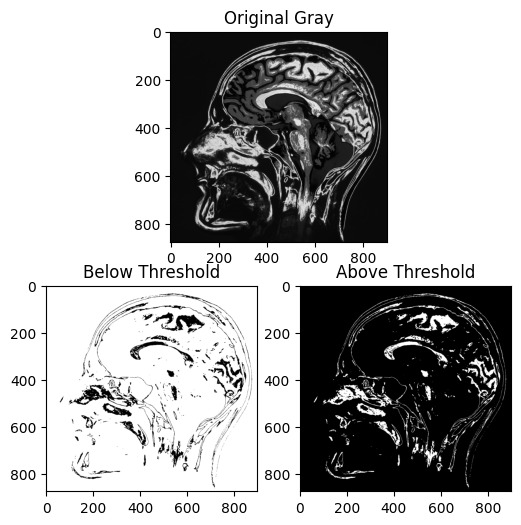

In [9]:
threshold = 190 #@param {type:"slider", min:0, max:255, step:5}

_, img_above = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY)
_, img_below = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1), plt.imshow(img_gray, cmap='gray'), plt.title('Original Gray')
plt.subplot(2, 2, 3), plt.imshow(img_below, cmap='gray'), plt.title('Below Threshold')
plt.subplot(2, 2, 4), plt.imshow(img_above, cmap='gray'), plt.title('Above Threshold')
plt.show()

You'll probably notice that some thresholds are better than others for keeping key parts of the image and removing others. You can determine the optimal threshold via trial-and-error.

However, `opencv` provides a technique called Otsu's method for automatically identifying the "optimal" threshold for your image. In short, this technique determines an optimal threshold value by examining the histogram of values in your image and identifying a reasonable value that logically splits it into two halves.

The code below shows the same binary thresholds but with Otsu's method (note that the value given as the `threshold` parameter does not matter, but it must be provided).

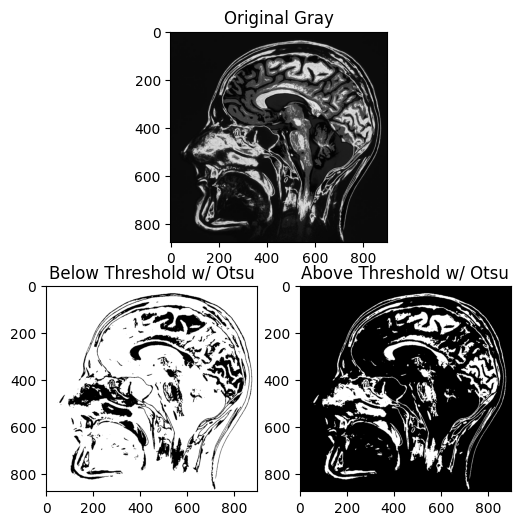

In [10]:
_, img_above_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, img_below_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1), plt.imshow(img_gray, cmap='gray'), plt.title('Original Gray')
plt.subplot(2, 2, 3), plt.imshow(img_below_otsu, cmap='gray'), plt.title('Below Threshold w/ Otsu')
plt.subplot(2, 2, 4), plt.imshow(img_above_otsu, cmap='gray'), plt.title('Above Threshold w/ Otsu')
plt.show()

# Adaptive Grayscale Thresholding

A global threshold may not make sense in all cases. For example, if a scene has different lighting in different regions, then a lower threshold should be used in the regions with dimmer lighting and a higher threshold should be used elsewhere.

In situations like these, we can use ***adaptive thresholding*** by calling `cv2.adaptiveThreshold()`. This function divides the image into distinct blocks (i.e., like a sliding window where width == stride), computes the ideal threshold for block, and then applies the local threshold to each block.

This function takes the following parameters:
* **img:** The image we want to threshold
* **maxval:** The highest possible value in our image (typically 255)
* **adaptiveMethod:** The type of theshold we want to apply:

| Threshold Type | Outcome |
|:-------:|:---------:|
| `cv2.ADAPTIVE_THRESH_MEAN_C` | The threshold is the mean of the neighborhood area minus the constant C |
| `cv2.ADAPTIVE_THRESH_GAUSSIAN_C` | The threshold is a Gaussian-weighted sum of the neighborhood values minus the constant C |

* **thresholdType:** The type of theshold we want to apply (see `cv2.threshold()`)
* **blockSize:** The width of the square blocks for determining local neighborhoods of pixels
* **C:** The constant referenced under `adaptiveMethod` (setting to a small positive value is usually good)


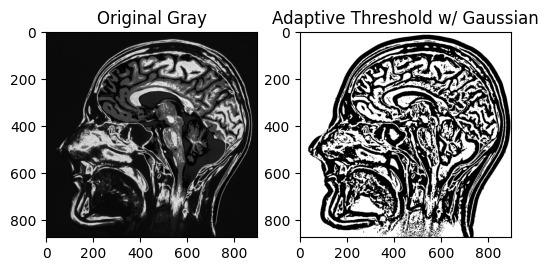

In [ ]:
blockSize = 51 #@param {type:"slider", min:11, max:51, step:10}
img_above_adaptmean = \
cv2.adaptiveThreshold(img_gray, 255,
                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, 2)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1), plt.imshow(img_gray, cmap='gray'), plt.title('Original Gray')
plt.subplot(1, 2, 2), plt.imshow(img_above_adaptmean, cmap='gray'), plt.title('Adaptive Threshold w/ Gaussian')
plt.show()

# Global Color Thresholding

The thresholding techniques we've discussed up until this point only work on grayscale images. As you can imagine, there will be times when you will want to apply thresholds to highlight pixels of a specific color. We can do this using the function `cv2.inRange()`.

Beyond accepting the original image as an input, the function `cv2.inRange()` allows you to specific the lower bound and upper bound for all the color channels in your image. The example below allows you to specify an RGB color and a tolerance for those values:

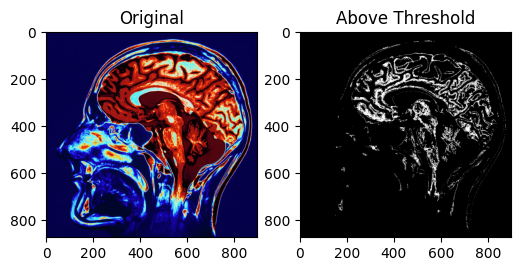

In [12]:
target_r = 190 #@param {type:"slider", min:0, max:255, step:5}
target_g = 0 #@param {type:"slider", min:0, max:255, step:5}
target_b = 0 #@param {type:"slider", min:0, max:255, step:5}
tolerance = 30 #@param {type:"slider", min:5, max:30, step:5}

# Define the boundaries
lower_bound = (target_r-tolerance, target_g-tolerance, target_b-tolerance)
upper_bound = (target_r+tolerance, target_g+tolerance, target_b+tolerance)

# Apply the threshold
img_thresh = cv2.inRange(img, lower_bound, upper_bound)

# Show the results
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1), plt.imshow(img), plt.title('Original')
plt.subplot(1, 2, 2), plt.imshow(img_thresh, cmap='gray'), plt.title('Above Threshold')
plt.show()

Coming up with the right bounds to isolate the desired part of an image can be challenging. Fortunately, this function works in any color space (including grayscale), so you can convert your image before thresholding your image if you find it easier to think about your desired output in a color space other than RGB. For example, the code cell below allows you to threshold an image according to the HSV color space.

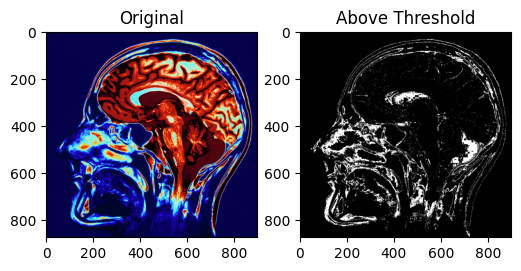

In [18]:
lower_h = 20 #@param {type:"slider", min:0, max:179, step:5}
upper_h = 90 #@param {type:"slider", min:0, max:179, step:5}
lower_s = 150 #@param {type:"slider", min:0, max:255, step:5}
upper_s = 255 #@param {type:"slider", min:0, max:255, step:5}
lower_v = 160 #@param {type:"slider", min:0, max:255, step:5}
upper_v = 255 #@param {type:"slider", min:0, max:255, step:5}

# Define the boundaries
lower_bound = (lower_h, lower_s, lower_v)
upper_bound = (upper_h, upper_s, upper_v)

# Apply the threshold on the HSV image
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_thresh = cv2.inRange(img, lower_bound, upper_bound)

# Show the results
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1), plt.imshow(img), plt.title('Original')
plt.subplot(1, 2, 2), plt.imshow(img_thresh, cmap='gray'), plt.title('Above Threshold')
plt.show()

# Combining Binary Images

What if you can't come up with a single threshold rule to get your desired output? For example, what if you wanted to get all of the pixels that were either near-white *or* near-black?

We can combine binary images using `cv2.bitwise_or()` and `cv2.bitwise_and()`. As their names imply, the first function combines two binary images using the logical "or" operator, while the second function combines two binary images using the logical "and" operator.

In the code cell below, we've used two separate thresholds to isolate extreme bright and dark regions in our grayscale image, and then we've combined those binary images using `cv2.bitwise_or()`.

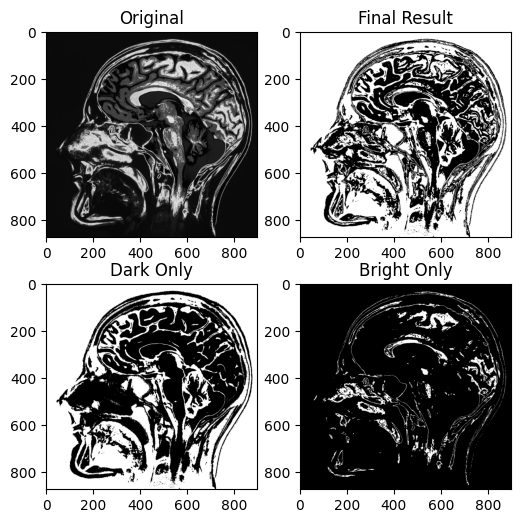

In [ ]:
# Filter for dark pixels
img_dark = cv2.inRange(img_gray, 0, 20)

# Filter for bright pixels
img_bright = cv2.inRange(img_gray, 200, 255)

# Combine into a final image
img_thresh = cv2.bitwise_or(img_dark, img_bright)

# Show the results
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1), plt.imshow(img_gray, cmap='gray'), plt.title('Original')
plt.subplot(2, 2, 2), plt.imshow(img_thresh, cmap='gray'), plt.title('Final Result')
plt.subplot(2, 2, 3), plt.imshow(img_dark, cmap='gray'), plt.title('Dark Only')
plt.subplot(2, 2, 4), plt.imshow(img_bright, cmap='gray'), plt.title('Bright Only')
plt.show()